# Working with gridded data

### Goals

- Gridded data concepts
  - Identify several examples of different types of gridded data
  - Explain what projection is; identify difference between geographic and UTM 
  - Identify common file types: geotiff, NetCDF, ESRI ASCII
- Digital elevation data
  - Explain what a digital elevation model is
  - Identify a few sources of DEMs
  - Know a couple of online sources for DEMs
  - Import a geotiff-format DEM using PIL Image
  - Perform calculations to derive attributes such as slope and aspect 
  - Use matplotlib's imshow() function to display images
  - Use mpl quiver() to visualize vector data

## Examples of gridded earth science data types

- Satellite images
- Digital photographs
- Interpolated data sets
- Digital elevation models (DEMs)
- Output from simulation models



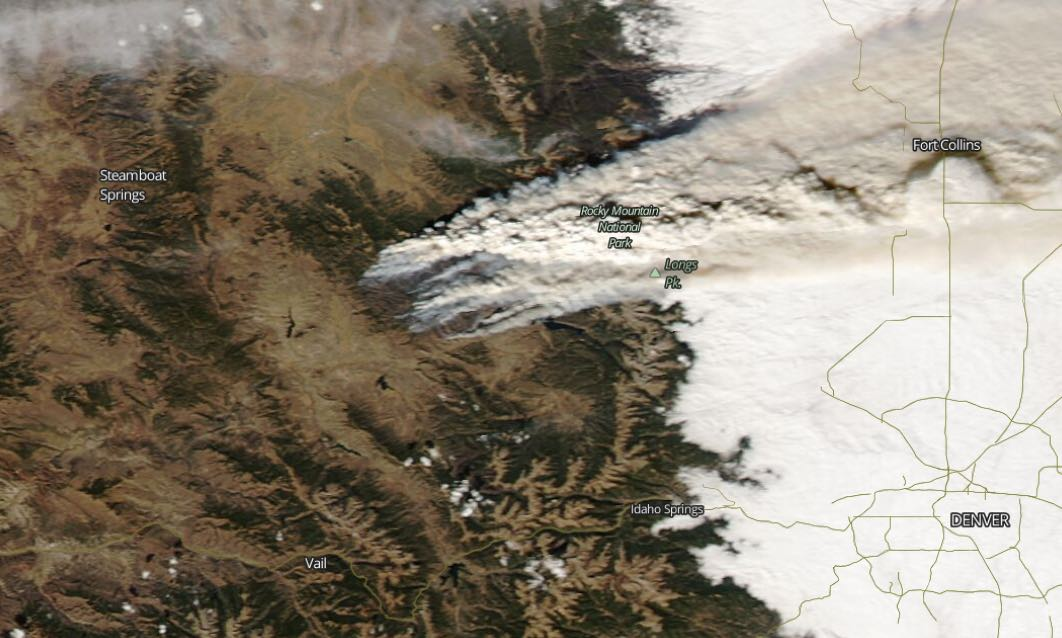

Maxar satellite image of East Troublesome Fire, October 2020

## Digital elevation model (DEM):

A gridded representation of the height of a surface, with an elevation value for each grid cell.

Common ways DEMs are made:
- Photogrammetry
- Laser scanning (lidar: light detection and ranging)
- Radar interferometry (ex: Shuttle Radar Topography Mission, SRTM)

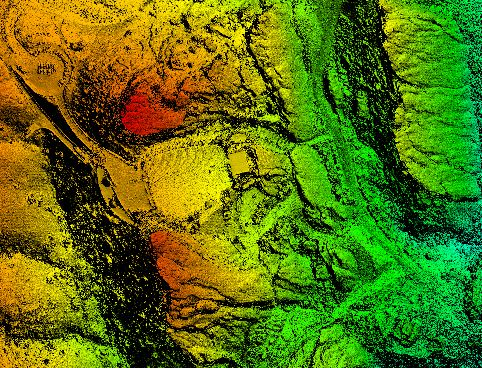

DEM of Red Rocks Amphitheatre (source: Stoermerjp  CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=24447099)

## Where can you find DEMs?

Many sources, including:

- [OpenTopography.org](https://OpenTopography.org)
- [US Geological Survey](https://www.usgs.gov/the-national-map-data-delivery/gis-data-download)
- [NOAA NCEI](https://www.ngdc.noaa.gov/mgg/topo/)

### Common DEM file formats

Some common formats include:

- GeoTIFF (binary) <== TODAY'S LESSON
- netCDF (binary)
- ESRI ASCII (text)
- ERDAS IMAGINE IMG (binary)

## Map projection

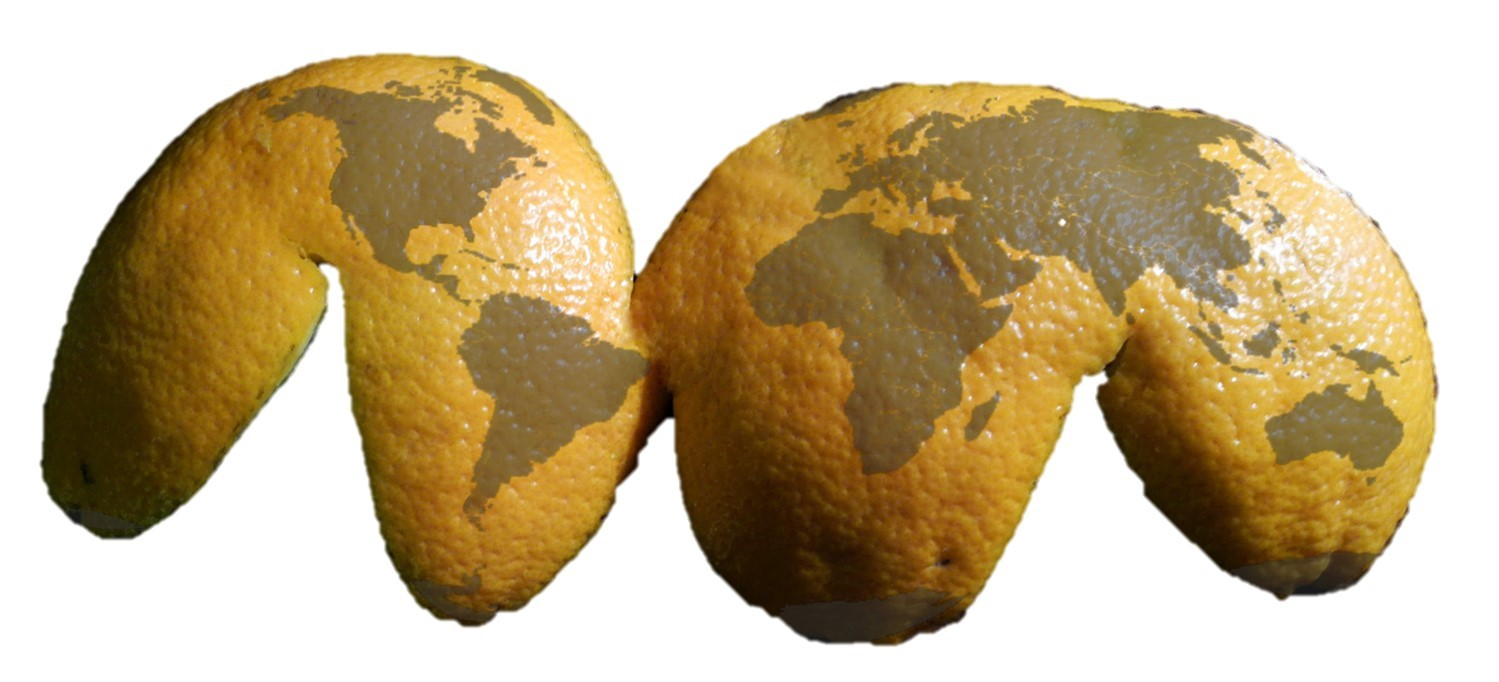

(Source: CC BY-NC-SA 3.0. Adapted from Anthony C. Robinson. Maps and the Geospatial Revolution, https://www.e-education.psu.edu/maps/l1_p5.html. Original photos Nathan P. Belz)

### Geographic versus projected coordinates

Geographic:
- Each point has a *latitude* (N-S) and *longitude* (E-W) in degrees, minutes, and seconds
- One degree of latitude equals about 111.2 km
- One degree of longitude depends on the latitude: 111.2 km x cos(latitude) (about 86 km in Boulder)

Projected:
- All or part of earth's surface is flattened
- Example: Universal Transverse Mercator (UTM) projection: 60 strips of 6 degrees longitude width each



(Source: By Chrismurf at English Wikipedia, CC BY 3.0, https://commons.wikimedia.org/w/index.php?curid=40690482)

### Example of coordinate-system options in Google Earth

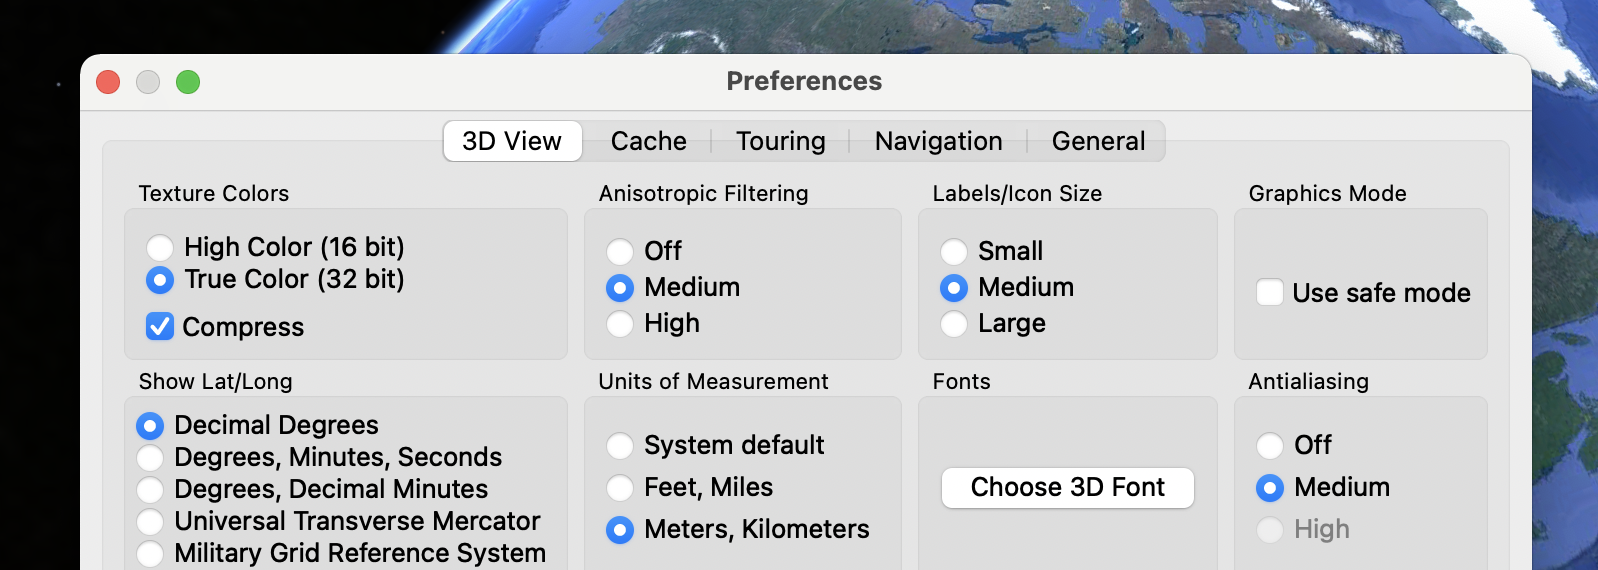

## Reading DEM from a GeoTIFF file

- Today's example: topography around Boulder
  - 1 x 1 degree "box" with grid cells of 1 arcsecond (~30 m) resolution
- Use Python Image Library (PIL) to import the data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
# Open the GeoTIFF file as a PIL Image object, and inspect it
img = Image.open("boulder39p5N-106W_NASADEM.tif")
print("The size of the image is", img.size)

In [ ]:
# Extract the values as a 2D numpy array
topo = np.array(img)
topo.shape

## Displaying images with `imshow`

The matplotlib.pyplot function `imshow()` displays a given image. Among the useful parameters are:

- `cmap` - name of colormap to use
- `vmin, vmax` - maximum and minimum values for coloring
- `extent` - extent of the data on x and y axes
- `aspect` - aspect ratio (default 1:1)

We'll also add a `colorbar`

```
plt.imshow(topo)
plt.colorbar(label="Elevation (m)")
```

In [ ]:
plt.imshow(topo)
plt.colorbar(label="Elevation (m)")

### Working out the pixel size

Each pixel is 1 arcsecond of latitude and longitude. How big is that in meters?

First, let's work out the length of one degree of latitude. Earth circumference = $2\pi r$ ($r$ = radius) encompasses 360 degrees. So one degree of latitude is:

$$L_d = 2\pi r / 360$$

Take the nominal radius to be 6,371 km (it's actually about 7 km longer at the equator and 14 km shorter at the poles). What do we get?

An arcsecond is 1/3600 of this value. How big is that in meters?

In [ ]:
# Length-of-degree calculation for latitude here
earth_radius = 6371.0 * 1000.0
Ld = 2 * np.pi * earth_radius / 360.0
print("Length of degree is", Ld)

# And for 1 arcsecond here
length_of_arcsec_lat = Ld / 3600.0
print(length_of_arcsec_lat)

### Working out pixel size, continued

A degree of longitude depends on the latitude: biggest at the equator, shrinking to zero at the poles. The formula is:

$$L_{lon} = L_d \cos \phi$$

where $\phi$ is latitude.

What's the value here at latitude 40 north? What's the length of one arcsecond at our latitude?



In [ ]:
# Calculate length-of-degree at 40 N here
length_of_degree_40 = Ld * np.cos(np.radians(40))
print(length_of_degree_40)

# Calculate length-of-arcsecond here
arc_sec_at40 = length_of_degree_40 / 3600.0
print(arc_sec_at40)

#### We can use this to scale our image plot in a crude form of projection

```
dy = 30.89
dx = dy * np.cos(np.radians(40.0))
plt.imshow(topo, extent=[0, 3600 * dx / 1000, 0, 3600 * dy / 1000])
plt.colorbar(label="Elevation (m)")
plt.xlabel("Distance east (km)")
plt.ylabel("Distance north (km)")
```

In [ ]:
dy = length_of_arcsec_lat
dx = arc_sec_at40
plt.imshow(topo, extent=[0, 3600 * dx / 1000.0, 0, 3600 * dy / 1000.0])
plt.colorbar(label="Elevation (m)")
plt.xlabel("Distance east (km)")
plt.ylabel("Distance north (km)")

### Changing the colormap

Matplotlib offers numerous colormaps. Take a look at the options here:

[https://matplotlib.org/stable/users/explain/colors/colormaps.html](https://matplotlib.org/stable/users/explain/colors/colormaps.html)

Try some out with the DEM. What colormaps are effective at highlighting different elements of the terrain?


In [ ]:
# Experiment with alternative colormaps here
dy = length_of_arcsec_lat
dx = arc_sec_at40
plt.imshow(topo, extent=[0, 3600 * dx / 1000.0, 0, 3600 * dy / 1000.0], cmap="terrain")
plt.colorbar(label="Elevation (m)")
plt.xlabel("Distance east (km)")
plt.ylabel("Distance north (km)")

## Calculating slope gradient on a DEM

One of the useful things you can do with a DEM is to calculate the slope angle or gradient across the land. We've already seen a couple of applications in rivers and gullies. Another application lies in mapping the relative susceptibility to landsliding.

Some things we can calculate include:

- Slope in a particular direction (say, north-south or east-west)
- **Magnitude** of the slope (how steep is it?)
- Direction of steepest ascent or descent


Imagine a "neighborhood" of 3x3 grid cells:
```
.---.---.---.
|   | d |   |
.---.---.---.
| a | o | b |
.---.---.---.
|   | c |   |
.---.---.---.
```
Spacing of cells is $\Delta x$ E-W, and $\Delta y$ N-S.

Gradient in the E-W direction is

$$s_x = \frac{b - a}{2\Delta x}$$

$$s_y = \frac{d - c}{2\Delta y}$$

Numpy `gradient()` function will do this for us: given a 2D array, it will return gradient in each direction.

Once we have $s_x$ and $s_y$, we can use the Pythagorean theorem to find the **magnitude**, $S$:

$$S = \sqrt{s_x^2 + s_y^2}$$

### Testing out a gradient calculation on a tiny DEM

In [ ]:
# Here we make up a tiny little 2d array
tiny_dem = (np.arange(12)**2).reshape((3, 4))
tiny_dem

In [ ]:
# Here we apply the numpy gradient() function
tiny_dx = 10.0 # suppose the grid spacing is 10 meters E-W...
tiny_dy = 100.0 # ...and 100 meters N-S
tsy, tsx = np.gradient(tiny_dem, tiny_dy, tiny_dx)
tsx, tsy

In [ ]:
# Gradient magnitude
St = np.sqrt(tsx**2 + tsy**2)
print(St)
plt.imshow(St)
plt.colorbar(label="Slope gradient")

### <div style="color:green">In-class practice</div>

Write a function that takes a DEM (in the form of a 2D array) and the cell spacing in y (N-S) and x (E-W) as input arguments, and calculates and returns the slope magnitude as a 2D array.

Run your function with the DEM for Boulder that we downloaded, then use `imshow()` to display the slope array.

In [ ]:
# (your code here)
sy, sx = np.gradient(topo, dy, dx)
S = np.sqrt(sy**2 + sx**2)
plt.imshow(S, vmin=0.0, vmax=1.0)
plt.colorbar(label="Slope gradient (m/m)")

## Contouring

Matplotlib's `contour()` function creates a contour plot.

Here's an example:

```
plt.imshow(topo, cmap="terrain")
plt.contour(topo, levels=np.arange(1200, 4000, 500), colors="k")
```

### Aspect

**Aspect** describes the direction a slope faces. A *south* aspect would tend to be sunnier (in the northern hemisphere) than a *north* aspect. An *east* aspect would face the sunrise; a *west* aspect would face the sunset.

To get aspect, as an angle around the compass, we can take the inverse tangent (or *arctangent*) of the x- and y-components of the slope gradient:

```
aspect = np.arctan2(-sx, sy)
```

#### Optional exercise

**Write a function to calculate and return aspect, and plot it.**

### A histogram of slope aspect

Does the Boulder area have more slopes that incline or one direction or another, or is the distribution more or less uniform? Using the `hist()` function on our aspect data should answer that question. Note that we need to apply the numpy `flatten()` method to our 2D array so that `hist()` will consider all the values collectively rather than one row at a time.

## Shaded relief

A **shaded relief** image, also known as a **hillshade**, displays a terrain as it might appear with lighting coming from a particular direction. The following function takes a 2D numpy array as an input parameter, and returns a hillshade image of the same size and shape:

In [ ]:
def hillshade(z, azimuth=315.0, angle_altitude=45.0):
    """Generate a hillshade image from DEM.

    Notes: adapted from example on GeoExamples blog,
    published March 24, 2014, by Roger Veciana i Rovira.
    """
    x, y = np.gradient(z)
    slope = np.pi / 2.0 - np.arctan(np.sqrt(x**2 + y**2))  # slope gradient
    aspect = np.arctan2(-x, y)  # aspect
    azimuthrad = azimuth * np.pi / 180.0  # convert lighting azimuth to radians
    altituderad = angle_altitude * np.pi / 180.0  # convert lighting altitude to radians
    shaded = np.sin(altituderad) * np.sin(slope) + np.cos(altituderad) * np.cos(
        slope
    ) * np.cos(azimuthrad - aspect)
    return 255 * (shaded + 1) / 2  # return result scaled 0 to 255

### Applying the hillshade function to the Boulder DEM

Let's try running this function on the Boulder DEM and displaying the resulting image with `imshow()`.

In [ ]:
# (code to generate and display hillshade here)

### Using transparency to combine data layers

You can get a nice effect by plotting a hillshade on top of an elevation image, and applying some transparency to the hillshade so the elevation image shows through.

To apply transparency to an image, use the `alpha` keyword argument. It represents opacity (one minus transparency), and takes a number from 0 to 1. Smaller = more visibility of the underlying layer.

In [ ]:
# To get a proper scale, define a 4-element list variable with your plot extent in km
#plot_extent = ... # (complete and uncomment this line)


# Use imshow to display a terrain image with the "terrain" colormap (cmap).
# Include extent=plot_extent.


# Use imshow to display the hillshade on top of it, using the alpha parameter to set
# opacity to 50%. Use the "gray" colorap. Remember to use extent=plot_extent. 

# Label your x and y axes



## Review

- Types and sources of gridded data generally
- Definition of a Digital Elevation Model (DEM)
- Sources and formats of DEMs
- Geographic coordinates and map projection
- Universal Transverse Mercator (UTM) coordinate system
- The Python Image Library (PIL)
- Displaying image data with `imshow()`
- Calculating slope and aspect
- Generating hillshade images

## Extra material if time allows

## Quiver plots and vector data

Slope magnitude and direction are a form of *vector data*. Other examples include windspeed and ocean current speed.

A **quiver plot** provides a way to visualize these data using arrows. Here's an example that makes a quiver plot of a small piece of the Boulder DEM around the flatirons:

In [ ]:
flatirons = topo[1700:2100,2500:2700]
syf, sxf = np.gradient(flatirons, 31, 28)
plt.quiver(-sxf[::10,::10], -syf[::10,::10])